# Preparation

In [1]:
import argparse
import os
import random

import numpy as np
import numpy.matlib

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader, random_split
from torch.autograd import Variable

import torchvision
import torchvision.datasets as dset
import torchvision.transforms.functional as TF
import torchvision.utils as vutils
from torchvision.transforms import Compose, Resize, ToTensor, ToPILImage

from scipy.spatial.distance import cdist

In [4]:
data_dir = '../input/fruit-recognition'

# Transform images

## Resize images

There are 70549 images.


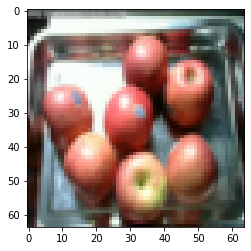

In [5]:
# Max = 258
pixels = 64

composed = Compose([Resize((pixels, pixels)), ToTensor()])

dataset = torchvision.datasets.ImageFolder(data_dir, composed)
print("There are {} images.".format(len(dataset)))

# An example image
plt.imshow(dataset[6][0].permute(1,2,0))

## Bit-depth reduction

In [ ]:
# Reduce bit-depth
pixels = 258
bits = 20

class BitDepthReduction:
    def __call__(self, image):
        image = TF.pil_to_tensor(image).float() / 255
        return torch.round(image * (2^bits - 1))/(2^bits - 1)

composed = Compose([Resize((pixels, pixels)), BitDepthReduction()])

In [ ]:
dataset = torchvision.datasets.ImageFolder(data_dir, composed)
print("There are {} images.".format(len(dataset)))

# An example image
plt.imshow(dataset[6][0].permute(1,2,0))
plt.savefig('figures/8-bits-apples.png')

## Resize to [pixel * x, pixel) & pad to pixel

In [ ]:
# Define image size & minimum resize size
pixels = 264
min_resize_ratio = 0.95

In [ ]:
minimum_resize = np.round_(pixels * min_resize_ratio)
print("Minimum resized size of image is:", minimum_resize, "pixels.")

In [ ]:
class RandomResize:
    def __call__(self, image):
        new_w = random.randint(minimum_resize, pixels)
        new_h = random.randint(minimum_resize, pixels)
        return TF.resize(image, [new_w, new_h])

class SquarePad:
    def __call__(self, image):
        W, H = image.size
        left = random.randint(0, pixels - W + 1)
        top = random.randint(0, pixels - W + 1)
        right = pixels - W - left
        bottom = pixels - H - top
        padding = (left, top, right, bottom)
        return TF.pad(image, padding)

composed = Compose([RandomResize(), SquarePad(), ToTensor()])

In [ ]:
dataset = torchvision.datasets.ImageFolder(data_dir, composed)

## Pad to pixel only

In [ ]:
class SquarePad:
    def __call__(self, image):
        padding = (3, 3, 3, 3)
        return TF.pad(image, padding)

composed = Compose([Resize((258, 258)), SquarePad(), ToTensor()])

In [ ]:
dataset = torchvision.datasets.ImageFolder(data_dir, composed)

## k-mean bit-depth reduction

In [ ]:
class k_mean_bit_depth:
    def __call__(self, image):
        centroids = np.random.normal(0, 1, size=(2**8, 3))
        for N in range(100):
            if N > 0:
                L_old = L_new
            # The assignments:
            assignments = np.zeros((258**2,2**8))
            
            image = np.array(image).reshape(258**2,3)
            
            # Distance to centroids
            dist = cdist(image, centroids)

            # Assignments:
            boolean = np.argmin(dist, axis = 1)
            for i in range(len(boolean)):
                assignments[i, boolean[i]] = 1

            # Objective function:
            L_new = np.sum(assignments*dist**2)

            # Recalculate centroids:
            for i in np.unique(boolean):
                centroids[i,:] = np.mean(image[[j == i for j in boolean]], axis = 0)

            if N > 0:
                if (L_old - L_new)/L_new <= 1e-9:
                    return np.matmul(assignments, centroids).reshape(258,258,3)
        return np.matmul(assignments, centroids).reshape(258,258,3)

In [ ]:
composed = Compose([Resize((258, 258)), k_mean_bit_depth(), ToTensor()])

In [ ]:
dataset = torchvision.datasets.ImageFolder(data_dir, composed)

# Divide data into sets

In [ ]:
# Create training, validation and test sets
val_size = 10509
test_size = 7000
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
print("Training set size:", len(train_ds))
print("Validation set size:", len(val_ds))
print("Test set size:", len(test_ds))

In [ ]:
# Set batch size & create loaders
batch_size = 10
train_loader = DataLoader(train_ds, batch_size, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, pin_memory=True)

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
# Show an image
plt.axis('off')
plt.imshow(images[0].data.detach().cpu().numpy())

# Define functions

In [ ]:
# Evaluate accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Create a base model class (no architecture)
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

# Training and assessment functions
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# Create a function to port stuff to GPU
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()

# create a function for transferring data to the GPU
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
    
# functions for displaying the error and accuracy of the model
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs')

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    
# FGSM attack
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# Test FGSM

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return sign_data_grad, perturbed_image

In [ ]:
def test(target_model, defense_model, device, test_loader, epsilon):
    # Loop over all examples in test set
    for data, target in test_loader:
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Remember gradients
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        sign_data_grad, perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        target_output = target_model(perturbed_data)
        
        # Check for success
        target_pred = target_output.max(1, keepdim=True)[1]
        
        print(target_pred)
        
        break
        
    return data, target, perturbed_data, sign_data_grad

In [ ]:
pretrained_model = 'new-model.pth'
model.load_state_dict(torch.load(pretrained_model, map_location=lambda storage, loc: storage.cuda(0)))

In [ ]:
test_loader = DataLoader(test_ds, batch_size=1, num_workers=4, pin_memory=True)

In [ ]:
data, target, perturbed_image, sign_data_grad = test(model, model, device, test_loader, 0.04)

In [ ]:
plt.axis('off')
plt.imshow(data[0].data.detach().cpu().numpy().transpose(1,2,0))
plt.savefig("figures/original-kiwi.png")

In [ ]:
plt.axis('off')
plt.imshow(sign_data_grad[0].data.detach().cpu().numpy().transpose(1,2,0))
plt.savefig("figures/noise.png")

In [ ]:
plt.axis('off')
plt.imshow(perturbed_image[0].data.detach().cpu().numpy().transpose(1,2,0))
plt.savefig("figures/attacked.png")

In [ ]:
output = model(sign_data_grad)
output.max(1, keepdim=True)[1]

# Port data to GPU

In [ ]:
# uploading data to the GPU
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

# Models

## Convo model (258 x 258)

In [ ]:
# extending the original model by adding neural network architecture
class FruitRecognitionModel(ImageClassificationBase):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(1032256, 128)
        self.fc2 = nn.Linear(128, out_size)
        
    def forward(self, x):
        # Pass data through conv1
        x = self.conv1(x)
        # Use the rectified-linear activation function over x
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        # Run max pooling over x
        x = F.max_pool2d(x, 2)
        # Pass data through dropout1
        x = self.dropout1(x)
        # Flatten x with start_dim=1
        x = torch.flatten(x, 1)
        # Pass data through fc1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        # Apply softmax to x
        output = F.log_softmax(x, dim=1)
        return output

## Convo model (128 x 128)

In [ ]:
# extending the original model by adding neural network architecture
class FruitRecognitionModel(ImageClassificationBase):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(246016, 128)
        self.fc2 = nn.Linear(128, out_size)
        
    def forward(self, x):
        # Pass data through conv1
        x = self.conv1(x)
        # Use the rectified-linear activation function over x
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        # Run max pooling over x
        x = F.max_pool2d(x, 2)
        # Pass data through dropout1
        x = self.dropout1(x)
        # Flatten x with start_dim=1
        x = torch.flatten(x, 1)
        # Pass data through fc1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        # Apply softmax to x
        output = F.log_softmax(x, dim=1)
        return output

## Convo model (64 x 64)

In [ ]:
# extending the original model by adding neural network architecture
class FruitRecognitionModel(ImageClassificationBase):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(57600, 128)
        self.fc2 = nn.Linear(128, out_size)
        
    def forward(self, x):
        # Pass data through conv1
        x = self.conv1(x)
        # Use the rectified-linear activation function over x
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        # Run max pooling over x
        x = F.max_pool2d(x, 2)
        # Pass data through dropout1
        x = self.dropout1(x)
        # Flatten x with start_dim=1
        x = torch.flatten(x, 1)
        # Pass data through fc1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        # Apply softmax to x
        output = F.log_softmax(x, dim=1)
        return output

## Five-layer linear model

In [ ]:
# extending the original model by adding neural network architecture
class FruitRecognitionModel(ImageClassificationBase):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 128)
        self.linear4 = nn.Linear(128, 32)
        self.linear5 = nn.Linear(32, out_size)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        return out

## Convo model (padded 264 x 264)

In [ ]:
# extending the original model by adding neural network architecture
class FruitRecognitionModel(ImageClassificationBase):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(1081600, 128)
        self.fc2 = nn.Linear(128, out_size)
        
    def forward(self, x):
        # Pass data through conv1
        x = self.conv1(x)
        # Use the rectified-linear activation function over x
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        # Run max pooling over x
        x = F.max_pool2d(x, 2)
        # Pass data through dropout1
        x = self.dropout1(x)
        # Flatten x with start_dim=1
        x = torch.flatten(x, 1)
        # Pass data through fc1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        # Apply softmax to x
        output = F.log_softmax(x, dim=1)
        return output

# Train model

In [ ]:
pixels = 258

In [ ]:
# determine the size of the input (image tensor size) and
# output (number of classes)
input_size = 3*pixels*pixels
output_size = len(classes)

In [ ]:
# porting the model to the GPU
model = to_device(FruitRecognitionModel(input_size, output_size), device)
to_device(model, device)

In [ ]:
%%time
# check the accuracy and losses on the validation sample
history = [evaluate(model, val_loader)]
history

In [ ]:
%%time
# we train the model, choosing empirically the optimal step and the number of epochs
history += fit(10, 0.01, model, train_loader, val_loader)

In [ ]:
# build a graph of losses
plot_losses(history)

In [ ]:
# build a graph of accuracy
plot_accuracies(history)

## Test model

In [ ]:
# check the model on a test sample
evaluate(model, test_loader)

## Save model

In [ ]:
# save the model
torch.save(model.state_dict(), '258-pixels-8-bits-convo.pth')

# Attack padded model

In [ ]:
data_dir = 'C:\\Users\\nguye\\OneDrive\\Documents\\0.05 new model'

In [ ]:
# reduce the original images to one size and transform them into tensors
dataset = ImageFolder(data_dir, composed)
print("There are {} images.".format(len(dataset)))

In [ ]:
val_size = 10000
test_size = 7000
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

In [ ]:
# set the batch size and create loaders
batch_size = 20
train_loader = DataLoader(train_ds, batch_size, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, pin_memory=True)

In [ ]:
# uploading data to the GPU
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
evaluate(model, test_loader)

# Attack convo model

In [ ]:
data_dir = 'C:\\Users\\nguye\\OneDrive\\Documents\\0.05 new model'

In [ ]:
pixels = 258

In [ ]:
# reduce the original images to one size and transform them into tensors
dsize = (pixels, pixels)
composed = Compose([Resize(dsize), ToTensor()])

dataset = ImageFolder(data_dir, composed)
print("There are {} images.".format(len(dataset)))

In [ ]:
val_size = 10000
test_size = 7000
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

In [ ]:
# set the batch size and create loaders
batch_size = 20
train_loader = DataLoader(train_ds, batch_size, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, pin_memory=True)

In [ ]:
# uploading data to the GPU
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
input_size = 3*258*258

In [ ]:
# extending the original model by adding neural network architecture
class FruitRecognitionModel(ImageClassificationBase):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(1032256, 128)
        self.fc2 = nn.Linear(128, out_size)
        
    def forward(self, x):
        # Pass data through conv1
        x = self.conv1(x)
        # Use the rectified-linear activation function over x
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        # Run max pooling over x
        x = F.max_pool2d(x, 2)
        # Pass data through dropout1
        x = self.dropout1(x)
        # Flatten x with start_dim=1
        x = torch.flatten(x, 1)
        # Pass data through fc1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)

        # Apply softmax to x
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
# porting the model to the GPU
model = to_device(FruitRecognitionModel(input_size, out_size=output_size), device)
to_device(model, device)

In [ ]:
pretrained_model = 'new-model.pth'
model.load_state_dict(torch.load(pretrained_model, map_location=lambda storage, loc: storage.cuda(0)))

In [ ]:
evaluate(model, test_loader)

## Attack normal & padded models

In [ ]:
# let's look at the resulting classes from directories
data_dir = 'C:\\Users\\nguye\\OneDrive\\Documents\\Fruits'
classes = os.listdir(data_dir)
print("There are {} fruits.".format(len(classes)))

In [ ]:
# reduce the original images to one size and transform them into tensors
pixels = 258
dsize = (pixels, pixels)
composed = Compose([Resize(dsize), ToTensor()])

dataset = ImageFolder(data_dir, composed)
print("There are {} images.".format(len(dataset)))

In [ ]:
# Create training, validation and test sets
val_size = 10500
test_size = 7000
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

In [ ]:
def test(target_model, defense_model, device, test_loader, epsilon):
    # Accuracy counter
    target_correct = 0
    defense_correct = 0

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Remember gradients
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        target_output = target_model(perturbed_data)
        
        # Defense model
        perturbed_data = ToPILImage()(perturbed_data[0]).convert("RGB")
        perturbed_data = composed(perturbed_data).unsqueeze(0).to(device='cuda')
        defense_output = defense_model(perturbed_data)

        # Check for success
        target_pred = target_output.max(1, keepdim=True)[1]
        defense_pred = defense_output.max(1, keepdim=True)[1]
        
        if target_pred.item() == target.item():
            target_correct += 1
        if defense_pred.item() == target.item():
            defense_correct += 1

    # Calculate final accuracy for this epsilon
    target_acc = target_correct/float(len(test_loader))
    defense_acc = defense_correct/float(len(test_loader))
    print("Epsilon: {}\tTarget Accuracy = {} / {} = {}".format(epsilon, target_correct, len(test_loader), target_acc))
    print("Epsilon: {}\tDefense Accuracy = {} / {} = {}".format(epsilon, defense_correct, len(test_loader), defense_acc))

In [ ]:
epsilons = [.01, .02, .05]

In [ ]:
# porting the model to the GPU
model = to_device(FruitRecognitionModel(input_size, output_size), device)
to_device(model, device)

In [ ]:
pretrained_model = 'new-model.pth'
model.load_state_dict(torch.load(pretrained_model, map_location=lambda storage, loc: storage.cuda(0)))

In [ ]:
# porting the model to the GPU
model1 = to_device(FruitRecognitionModel(input_size, output_size), device)
to_device(model1, device)

In [ ]:
pretrained_model = '264-pixels-resized-padded-convo.pth'

In [ ]:
pretrained_model = '258-pixels-8-bits-convo.pth'

In [ ]:
model.load_state_dict(torch.load(pretrained_model, map_location=lambda storage, loc: storage.cuda(0)))

In [ ]:
test_loader = DataLoader(test_ds, batch_size=1, num_workers=4, pin_memory=True)

In [ ]:
# Run test for each epsilon
for eps in epsilons:
    test(model, model, device, test_loader, eps)

In [ ]:
test(model, model1, device, test_loader, 0.05)

## Attack normal & bit-depth model

In [ ]:
# Reduce bit-depth
bits = 8

class BitDepthReduction:
    def __call__(self, image):
        image = TF.pil_to_tensor(image).float() / 255
        return torch.round(image * (2^bits - 1))/(2^bits - 1) * 255

composed = Compose([Resize((pixels, pixels)), BitDepthReduction()])

In [ ]:
def test(target_model, defense_model, device, test_loader, epsilon):
    # Accuracy counter
    target_correct = 0
    defense_correct = 0

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Remember gradients
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        target_output = target_model(perturbed_data)
        
        # Defense model
        perturbed_data = ToPILImage()(perturbed_data[0]).convert("RGB")
        perturbed_data = composed(perturbed_data).unsqueeze(0).to(device='cuda')
        defense_output = defense_model(perturbed_data)

        # Check for success
        target_pred = target_output.max(1, keepdim=True)[1]
        defense_pred = defense_output.max(1, keepdim=True)[1]
        
        if target_pred.item() == target.item():
            target_correct += 1
        if defense_pred.item() == target.item():
            defense_correct += 1

    # Calculate final accuracy for this epsilon
    target_acc = target_correct/float(len(test_loader))
    defense_acc = defense_correct/float(len(test_loader))
    print("Epsilon: {}\tTarget Accuracy = {} / {} = {}".format(epsilon, target_correct, len(test_loader), target_acc))
    print("Epsilon: {}\tDefense Accuracy = {} / {} = {}".format(epsilon, defense_correct, len(test_loader), defense_acc))

In [ ]:
epsilons = [.03, .04, .06]

In [ ]:
test_loader = DataLoader(test_ds, batch_size=1, num_workers=4, pin_memory=True)

In [ ]:
pretrained_model = 'new-model.pth'
model.load_state_dict(torch.load(pretrained_model, map_location=lambda storage, loc: storage.cuda(0)))

In [ ]:
pretrained_model = '258-pixels-8-bits-convo.pth'
model.load_state_dict(torch.load(pretrained_model, map_location=lambda storage, loc: storage.cuda(0)))

In [ ]:
%%time
# 8 bits with 255 RGB scale
# Run test for each epsilon
for eps in epsilons:
    test(model, model, device, test_loader, eps)

In [ ]:
%%time
# 20 bits
# Run test for each epsilon
for eps in epsilons:
    test(model, model, device, test_loader, eps)

In [ ]:
%%time
# 10 bits
# Run test for each epsilon
for eps in epsilons:
    test(model, model, device, test_loader, eps)

In [ ]:
%%time
# 6 bits
# Run test for each epsilon
for eps in epsilons:
    test(model, model, device, test_loader, eps)

In [ ]:
%%time
# 5 bits
# Run test for each epsilon
for eps in epsilons:
    test(model, model, device, test_loader, eps)

In [ ]:
%%time
# 1 bit
# Run test for each epsilon
for eps in epsilons:
    test(model, model, device, test_loader, eps)

## k-means clustering with bit-depth

In [ ]:
def k_means_clustering(data, no_of_clusters, centroids=None, maximum_counter=300, tolerance=1e-9, \
                       print_output=10):    
    # Initialise centroids if blank:
    if centroids is None:
        centroids = np.random.normal(0, 1, size=(no_of_clusters, data.shape[-1]))
    else:
        centroids = centroids.astype(np.float)
    
    for N in range(maximum_counter):
        if N > 0:
            L_old = L_new
        # The assignments:
        assignments = np.zeros((data.shape[0],no_of_clusters))
        
        # Distance to centroids
        dist = cdist(data, centroids)
        
        # Assignments:
        boolean = np.argmin(dist, axis = 1)
        for i in range(len(boolean)):
            assignments[i, boolean[i]] = 1
        
        # Objective function:
        L_new = np.sum(assignments*dist**2)
        
        # Recalculate centroids:
        for i in np.unique(boolean):
            centroids[i,:] = np.mean(data[[j == i for j in boolean]], axis = 0)
        
        if N > 0:
            if (L_old - L_new)/L_new <= tolerance:
                return centroids, assignments
        
    return centroids, assignments

In [ ]:
%%time
no_of_bits = 8
centroids, assignments = k_means_clustering(images[0].data.detach().cpu().numpy().transpose(1,2,0).reshape(258*258, 3), 2**no_of_bits)

In [ ]:
approximation = np.matmul(assignments, centroids).reshape(258,258,3)

In [ ]:
fig=plt.figure(figsize=(15, 5))

fig.add_subplot(1, 2, 1)
plt.imshow(images[0].data.detach().cpu().numpy().transpose(1,2,0))
plt.axis('off')
plt.tight_layout;

fig.add_subplot(1, 2, 2)
plt.imshow(approximation)
plt.axis('off')
plt.tight_layout;

plt.show()

In [ ]:
def test(target_model, defense_model, device, test_loader, epsilon):
    # Accuracy counter
    target_correct = 0
    defense_correct = 0
    counter = 0

    # Loop over all examples in test set
    for data, target in test_loader:        
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Remember gradients
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        target_output = target_model(perturbed_data)
        
        # Defense model
        centroids, assignments = k_means_clustering(perturbed_data[0].data.detach().cpu().numpy().transpose(1,2,0).reshape(258*258,3), 2**no_of_bits)
        perturbed_data = torch.FloatTensor(np.matmul(assignments, centroids).reshape(1,3,258,258)).to(device='cuda')
        defense_output = defense_model(perturbed_data)

        # Check for success
        target_pred = target_output.max(1, keepdim=True)[1]
        defense_pred = defense_output.max(1, keepdim=True)[1]
        
        if target_pred.item() == target.item():
            target_correct += 1
        if defense_pred.item() == target.item():
            defense_correct += 1
            
        counter += 1
        print(counter)
        if counter == 100:
            break

    # Calculate final accuracy for this epsilon
    target_acc = target_correct/float(len(test_loader))
    defense_acc = defense_correct/float(len(test_loader))
    print(epsilon)
    print(target_correct)
    print(defense_correct)
    print("Epsilon: {}\tTarget Accuracy = {} / {} = {}".format(epsilon, target_correct, len(test_loader), target_acc))
    print("Epsilon: {}\tDefense Accuracy = {} / {} = {}".format(epsilon, defense_correct, len(test_loader), defense_acc))

In [ ]:
test_loader = DataLoader(test_ds, batch_size=1, num_workers=4, pin_memory=True)

In [ ]:
%%time
# 8 bits with 255 RGB scale
# Run test for each epsilon
for eps in epsilons:
    test(model, model, device, test_loader, eps)

## Single pattern attack

### New model (258 x 258)

In [ ]:
%%time
# we train the model, choosing empirically the optimal step and the number of epochs
history += fit(15, 0.01, model, train_loader, val_loader)

In [ ]:
# build a graph of losses
plot_losses(history)

In [ ]:
# build a graph of accuracy
plot_accuracies(history)

In [ ]:
# check the model on a test sample
evaluate(model, test_loader)

In [ ]:
# save the model
torch.save(model.state_dict(), 'new-model.pth')

### 5 layers model (150 x 150)

In [ ]:
%%time
# we train the model, choosing empirically the optimal step and the number of epochs
history += fit(13, 0.01, model, train_loader, val_loader)

In [ ]:
# build a graph of losses
plot_losses(history)

In [ ]:
# build a graph of accuracy
plot_accuracies(history)

In [ ]:
# save the model
torch.save(model.state_dict(), '5-layer-150.pth')

### 5 layers model (258 x 258)

In [ ]:
%%time
# we train the model, choosing empirically the optimal step and the number of epochs
history += fit(13, 0.01, model, train_loader, val_loader)

In [ ]:
# build a graph of losses
plot_losses(history)

In [ ]:
# build a graph of accuracy
plot_accuracies(history)

In [ ]:
# check the model on a test sample
evaluate(model, test_loader)

In [ ]:
# save the model
torch.save(model.state_dict(), '5-layer-model.pth')

# Universal Perturbations

In [ ]:
pretrained_model = 'new-model.pth'
model.load_state_dict(torch.load(pretrained_model, map_location=lambda storage, loc: storage.cuda(0)))

In [ ]:
perturbation = Variable(torch.zeros(3, pixels, pixels, requires_grad=True).to(device='cuda'))

In [ ]:
stepsize = 0.01
optimiser = optim.SGD(model.parameters(), lr=stepsize, momentum=0.7)
epsilon = 30

torch.autograd.set_detect_anomaly(True)

for data, target in train_loader:
    data.requires_grad = True
    perturbation.requires_grad = True
    perturbation.retain_grad()
    output_1 = model(data)
    output_2 = model(data + perturbation.repeat(10,1,1,1))

    loss_1 = F.nll_loss(output_1, target)
    loss_2 = F.nll_loss(output_2, target)
    loss = (loss_1 + loss_2) / 2
    model.zero_grad()
    loss.backward()

    optimiser.step()
     
    perturbation.data = perturbation.data + stepsize * perturbation.grad
    perturbation.data = (perturbation.data / torch.norm(perturbation.data.view(-1, 66564))
                        * epsilon)
    perturbation.data[perturbation.data != perturbation.data] = 0

In [ ]:
plt.axis('off')
plt.imshow(perturbation.data.detach().cpu().numpy().transpose(1, 2, 0))
plt.savefig("figures/universal-pertubation.png", bbox_inches='tight')

In [ ]:
# save the model
torch.save(model.state_dict(), '258-pixels-convo-ad-trained2.pth')

In [ ]:
# save the model
torch.save(model.state_dict(), '258-pixels-convo-ad-trained.pth')

In [ ]:
model.eval()

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
# Show a normal image
plt.axis('off')
plt.imshow(images[0].data.detach().cpu().numpy().transpose(1,2,0))
plt.savefig("figures/before.png", bbox_inches='tight')

In [ ]:
# Show an altered image
plt.axis('off')
plt.imshow((images[0]+perturbation.data).data.detach().cpu().numpy().transpose(1,2,0))
plt.savefig("figures/after.png", bbox_inches='tight')

# Testing

In [ ]:
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)

In [ ]:
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
def test_accuracy(model, test_loader, perturbation):
    # Accuracy counter
    correct = 0
    adv_examples = []
    
    # Loop over all examples in test set
    for data, target in test_loader:
        # Forward pass the data through the model
        perturbed_data = data + perturbation
        output = model(perturbed_data)
        
        # Check for success
        final_pred = output.max(1, keepdim=True)[1][0]
        
        if final_pred.item() == target.item():
            correct += 1
        
    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Test Accuracy = {} / {} = {}".format(correct, len(test_loader), final_acc))

    return final_acc, adv_examples

In [ ]:
x = torch.zeros(3, 258, 258).to(device='cuda')

In [ ]:
acc_1, ex_1 = test_accuracy(model, test_loader, x)

In [ ]:
acc_2, ex_2 = test_accuracy(model, test_loader, perturbation)

In [ ]:
pretrained_model = 'new-model.pth'
model.load_state_dict(torch.load(pretrained_model, map_location=lambda storage, loc: storage.cuda(0)))

In [ ]:
acc_3, ex_3 = test_accuracy(model, test_loader, perturbation)

# PyTorch attack

## Save attacked images

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [ ]:
pretrained_model = 'new-model.pth'
model.load_state_dict(torch.load(pretrained_model, map_location=lambda storage, loc: storage.cuda(0)))

In [ ]:
trainloader_1 = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=2)

In [ ]:
def genadversarial(model, device, test_loader):
    i = 0
    for data, target in test_loader:
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
    
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, 0.05, data_grad)
        plt.imsave('0.05 new model\\{}\\{}.png'.format(classes[int(target)],i), perturbed_data.detach().cpu().numpy()[0].transpose(1,2,0))
        i+=1

In [ ]:
%%time
genadversarial(model, device, trainloader_1)

## Train model again

In [ ]:
data_dir = 'C:\\Users\\nguye\\OneDrive\\Documents\\Fruits (2)'

In [ ]:
# reduce the original images to one size and transform them into tensors
dataset = ImageFolder(data_dir, composed)
print("There are {} images.".format(len(dataset)))

In [ ]:
# create training and validation samples from the initial dataset
torch.manual_seed(43)

val_size = 20000
test_size = 14000
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

In [ ]:
# set the batch size and create loaders for the resulting samples using DataLoader
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

In [ ]:
# porting the model to the GPU
model = to_device(FruitRecognitionModel(input_size, out_size=output_size), device)
to_device(model, device)

In [ ]:
# uploading data to the GPU
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
# check the accuracy and losses on the validation sample
history = [evaluate(model, val_loader)]
history

In [ ]:
%%time
# we train the model, choosing empirically the optimal step and the number of epochs
history += fit(10, 0.01, model, train_loader, val_loader)

In [ ]:
# build a graph of losses
plot_losses(history)

In [ ]:
# build a graph of accuracy
plot_accuracies(history)

In [ ]:
# check the model on a test sample
evaluate(model, test_loader)

In [ ]:
# save the model
torch.save(model.state_dict(), '5-layer-model-robust.pth')

## Attack robust model

In [ ]:
data_dir = 'C:\\Users\\nguye\\OneDrive\\Documents\\Fruits'

In [ ]:
dataset = ImageFolder(data_dir, composed)
print("There are {} images.".format(len(dataset)))

In [ ]:
val_size = 10500
test_size = 7000
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

In [ ]:
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
epsilons = [0, .01, .02, .03, .04, .05, .06]
pretrained_model = '5-layer-model-robust.pth'

In [ ]:
model.load_state_dict(torch.load(pretrained_model, map_location=lambda storage, loc: storage.cuda(0)))

In [ ]:
test_loader = DataLoader(test_ds, batch_size=1, num_workers=4, pin_memory=True)

In [ ]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [ ]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .065, step=0.01))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

## Rotation

In [ ]:
epsilons = [0, .01, .02, .03, .04, .05, .06]
pretrained_model = "fruit-recognition-model.pth"
use_cuda=True

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.utils import _pair, _quadruple


class MedianPool2d(nn.Module):
    """ Median pool (usable as median filter when stride=1) module.
    
    Args:
         kernel_size: size of pooling kernel, int or 2-tuple
         stride: pool stride, int or 2-tuple
         padding: pool padding, int or 4-tuple (l, r, t, b) as in pytorch F.pad
         same: override padding and enforce same padding, boolean
    """
    def __init__(self, kernel_size=3, stride=1, padding=0, same=False):
        super(MedianPool2d, self).__init__()
        self.k = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _quadruple(padding)  # convert to l, r, t, b
        self.same = same

    def _padding(self, x):
        if self.same:
            ih, iw = x.size()[2:]
            if ih % self.stride[0] == 0:
                ph = max(self.k[0] - self.stride[0], 0)
            else:
                ph = max(self.k[0] - (ih % self.stride[0]), 0)
            if iw % self.stride[1] == 0:
                pw = max(self.k[1] - self.stride[1], 0)
            else:
                pw = max(self.k[1] - (iw % self.stride[1]), 0)
            pl = pw // 2
            pr = pw - pl
            pt = ph // 2
            pb = ph - pt
            padding = (pl, pr, pt, pb)
        else:
            padding = self.padding
        return padding
    
    def forward(self, x):
        # using existing pytorch functions and tensor ops so that we get autograd, 
        # would likely be more efficient to implement from scratch at C/Cuda level
        x = F.pad(x, self._padding(x), mode='reflect')
        x = x.unfold(2, self.k[0], self.stride[0]).unfold(3, self.k[1], self.stride[1])
        x = x.contiguous().view(x.size()[:4] + (-1,)).median(dim=-1)[0]
        return x

In [ ]:
m = MedianPool2d()

In [ ]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        perturbed_data = tfms(perturbed_data)
        
        # Re-classify the perturbed image
        output = model(perturbed_data)
        
        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [ ]:
import torchvision.transforms.functional as TF

tfms = Compose([torchvision.transforms.Resize(250), torchvision.transforms.Pad(4)])

dataloader_iterator = iter(test_loader)
for i in range(1):
    try:
        data, target = next(dataloader_iterator)
    except StopIteration:
        dataloader_iterator = iter(dataloader)
        data, target = next(dataloader_iterator)
    data = tfms(data)
    print(plt.imshow(data[0].detach().cpu().numpy().transpose(1,2,0)))

In [ ]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .065, step=0.01))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

## Normal FGSM attack

In [ ]:
epsilons = [0, .01, .02, .03, .04, .05, .06]
pretrained_model = "264-pixels-resized-padded-convo.pth"

In [ ]:
def test(model, device, test_loader, epsilon):
    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        print("done")
        
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [ ]:
model.load_state_dict(torch.load(pretrained_model, map_location=lambda storage, loc: storage.cuda(0)))

In [ ]:
test_loader = DataLoader(test_ds, batch_size=1, num_workers=4, pin_memory=True)

In [ ]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .065, step=0.01))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(11,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        orig = classes[orig]
        adv = classes[adv]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex.transpose(1, 2, 0))
plt.tight_layout()
plt.savefig('figures/attack1.png')
plt.show()

## Attack new model

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [ ]:
epsilons = [0, .01, .02, .03, .04, .05, .06]
pretrained_model = "new-model.pth"

In [ ]:
def test( model, device, test_loader, epsilon ):
    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [ ]:
model.load_state_dict(torch.load(pretrained_model, map_location=lambda storage, loc: storage.cuda(0)))

In [ ]:
test_loader = DataLoader(test_ds, batch_size=1, num_workers=4, pin_memory=True)

In [ ]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .065, step=0.01))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

## Padding

In [ ]:
tfms = Compose([torchvision.transforms.Resize(256), torchvision.transforms.Pad(1)])

In [ ]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.cross_entropy(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        perturbed_data = tfms(perturbed_data)
        
        # Re-classify the perturbed image
        output = model(perturbed_data)
        
        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [ ]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .065, step=0.01))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

# Defence

In [ ]:
"""Implementation of sample defense.
This defense loads inception resnet v2 checkpoint and classifies all images
using loaded checkpoint.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

import random

import numpy as np
from scipy.misc import imread

import tensorflow as tf

import inception_resnet_v2

slim = tf.contrib.slim


tf.flags.DEFINE_string(
    'master', '', 'The address of the TensorFlow master to use.')

tf.flags.DEFINE_string(
    'checkpoint_path', '', 'Path to checkpoint for inception network.')

tf.flags.DEFINE_string(
    'input_dir', '', 'Input directory with images.')

tf.flags.DEFINE_string(
    'output_file', '', 'Output file to save labels.')

tf.flags.DEFINE_integer(
    'image_width', 299, 'Width of each input images.')

tf.flags.DEFINE_integer(
    'image_height', 299, 'Height of each input images.')

tf.flags.DEFINE_integer(
    'batch_size', 16, 'How many images process at one time.')

tf.flags.DEFINE_integer(
    'image_resize', 331, 'Resize of image size.')

FLAGS = tf.flags.FLAGS



def padding_layer_iyswim(inputs, shape, name=None):
    h_start = shape[0]
    w_start = shape[1]
    output_short = shape[2]
    input_shape = tf.shape(inputs)
    input_short = tf.reduce_min(input_shape[1:3])
    input_long = tf.reduce_max(input_shape[1:3])
    output_long = tf.to_int32(tf.ceil(
        1. * tf.to_float(output_short) * tf.to_float(input_long) / tf.to_float(input_short)))
    output_height = tf.to_int32(input_shape[1] >= input_shape[2]) * output_long +\
        tf.to_int32(input_shape[1] < input_shape[2]) * output_short
    output_width = tf.to_int32(input_shape[1] >= input_shape[2]) * output_short +\
        tf.to_int32(input_shape[1] < input_shape[2]) * output_long
    return tf.pad(inputs, tf.to_int32(tf.stack([[0, 0], [h_start, output_height - h_start - input_shape[1]], [w_start, output_width - w_start - input_shape[2]], [0, 0]])), name=name)


def load_images(input_dir, batch_shape):
    """Read png images from input directory in batches.
    Args:
      input_dir: input directory
      batch_shape: shape of minibatch array, i.e. [batch_size, height, width, 3]
    Yields:
      filenames: list file names without path of each image
        Lenght of this list could be less than batch_size, in this case only
        first few images of the result are elements of the minibatch.
      images: array with all images from this batch
    """
    images = np.zeros(batch_shape)
    filenames = []
    idx = 0
    batch_size = batch_shape[0]
    for filepath in tf.gfile.Glob(os.path.join(input_dir, '*.png')):
        with tf.gfile.Open(filepath) as f:
            image = imread(f, mode='RGB').astype(np.float) / 255.0
        # Images for inception classifier are normalized to be in [-1, 1] interval.
        images[idx, :, :, :] = image * 2.0 - 1.0
        filenames.append(os.path.basename(filepath))
        idx += 1
        if idx == batch_size:
            yield filenames, images
            filenames = []
            images = np.zeros(batch_shape)
            idx = 0
    if idx > 0:
        yield filenames, images


def main(_):
    batch_shape = [FLAGS.batch_size, FLAGS.image_height, FLAGS.image_width, 3]
    num_classes = 1001
    itr = 30

    tf.logging.set_verbosity(tf.logging.INFO)

    with tf.Graph().as_default():
        # Prepare graph
        x_input = tf.placeholder(tf.float32, shape=batch_shape)
        img_resize_tensor = tf.placeholder(tf.int32, [2])
        x_input_resize = tf.image.resize_images(x_input, img_resize_tensor, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        shape_tensor = tf.placeholder(tf.int32, [3])
        padded_input = padding_layer_iyswim(x_input_resize, shape_tensor)
        # 330 is the last value to keep 8*8 output, 362 is the last value to keep 9*9 output, stride = 32
        padded_input.set_shape(
            (FLAGS.batch_size, FLAGS.image_resize, FLAGS.image_resize, 3))

        with slim.arg_scope(inception_resnet_v2.inception_resnet_v2_arg_scope()):
            _, end_points = inception_resnet_v2.inception_resnet_v2(
                padded_input, num_classes=num_classes, is_training=False, create_aux_logits=True)

        predicted_labels = tf.argmax(end_points['Predictions'], 1)

        # Run computation
        saver = tf.train.Saver(slim.get_model_variables())
        session_creator = tf.train.ChiefSessionCreator(
            scaffold=tf.train.Scaffold(saver=saver),
            checkpoint_filename_with_path=FLAGS.checkpoint_path,
            master=FLAGS.master)

        with tf.train.MonitoredSession(session_creator=session_creator) as sess:
            with tf.gfile.Open(FLAGS.output_file, 'w') as out_file:
                for filenames, images in load_images(FLAGS.input_dir, batch_shape):
                    final_preds = np.zeros(
                        [FLAGS.batch_size, num_classes, itr])
                    for j in range(itr):
                        if np.random.randint(0, 2, size=1) == 1:
                            images = images[:, :, ::-1, :]
                        resize_shape_ = np.random.randint(310, 331)
                        pred, aux_pred = sess.run([end_points['Predictions'], end_points['AuxPredictions']],
                                                        feed_dict={x_input: images, img_resize_tensor: [resize_shape_]*2,
                                                                   shape_tensor: np.array([random.randint(0, FLAGS.image_resize - resize_shape_), random.randint(0, FLAGS.image_resize - resize_shape_), FLAGS.image_resize])})
                        final_preds[..., j] = pred + 0.4 * aux_pred
                    final_probs = np.sum(final_preds, axis=-1)
                    labels = np.argmax(final_probs, 1)
                    for filename, label in zip(filenames, labels):
                        out_file.write('{0},{1}\n'.format(filename, label))


if __name__ == '__main__':
    tf.app.run()

# 64x64 GAN

In [ ]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [ ]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Training GAN

In [ ]:
pretrained_model = '64-discriminative.pth'
netD.load_state_dict(torch.load(pretrained_model, map_location=lambda storage, loc: storage.cuda(0)))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
# Save generative model
torch.save(netG.state_dict(), '64-generative.pth')

In [ ]:
# Save generative model
torch.save(netD.state_dict(), '64-discriminative.pth')

# 128x128 GAN

In [ ]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 200

# Size of feature maps in generator
ngf = 128

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers; 0.0005 is too high
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16 
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )
    
    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16 
            nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # state size. 1
        )
    
    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
pretrained_model = '128-discriminative.pth'
netD.load_state_dict(torch.load(pretrained_model, map_location=lambda storage, loc: storage.cuda(0)))

In [ ]:
# From: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
# Save generative model
torch.save(netG.state_dict(), '128-generative.pth')

In [ ]:
# Save discriminative model
torch.save(netD.state_dict(), '128-discriminative.pth')

# Generate a picture close to original picture

In [ ]:
pretrained_model = '64-pixels-convo.pth'
model.load_state_dict(torch.load(pretrained_model, map_location=lambda storage, loc: storage.cuda(0)))

In [ ]:
pretrained_model = '64-generative.pth'
netG.load_state_dict(torch.load(pretrained_model, map_location=lambda storage, loc: storage.cuda(0)))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size=1, num_workers=4, pin_memory=True), device)

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

In [ ]:
# Show a normal image
plt.axis('off')
plt.imshow(images[0].data.detach().cpu().numpy().transpose(1,2,0))
plt.savefig('figures/original guava.png')

In [ ]:
labels

In [ ]:
# Next image
images, labels = next(dataiter)

In [ ]:
# Show a normal image
plt.axis('off')
plt.imshow(images[0].data.detach().cpu().numpy().transpose(1,2,0))
#plt.savefig('figures/original pear.png')

## Visualise GAN images

In [ ]:
def train_loop(image, model, loss_fn, R, L): 
    for i in range(R):
        a = torch.randn(1, nz, 1, 1, device=device)
        pred = model(a)
        loss = loss_fn(pred, image)
        if i == 0:
            minimum_loss = loss
            random = a
        elif loss < minimum_loss:
            minimum_loss = loss
            random = a
        
    for i in range(L):
        # Compute prediction and loss
        random.requires_grad = True
        random.retain_grad()
        
        pred = model(random)
        loss = loss_fn(pred, image)
        
        model.zero_grad()
        loss.backward(retain_graph=True)
        
        random.data -= 0.1*random.grad.data
    
    return model(random)

In [ ]:
# Initialize the loss function
loss_fn = nn.MSELoss()

In [ ]:
%%time
fig = plt.figure(figsize=(18.5, 10.5))
columns = 7
rows = 5

dataiter = iter(test_loader)

# ax enables access to manipulate each of subplots
ax = []

for i in range(rows):
    # select image
    data, target = next(dataiter)
    img = data[0].data.detach().cpu().numpy().transpose(1, 2, 0)
    # create subplot and append to ax
    ax.append(fig.add_subplot(rows, columns, (i*columns)+1))
    # set title
    ax[0].set_title("Original", fontdict = {'fontsize': 16}, fontproperties=font)
    # remove axes
    ax[-1].xaxis.set_visible(False)
    ax[-1].yaxis.set_visible(False)
    # put image to display
    plt.imshow(img)
    
    # adversarial images
    # create subplot and append to ax
    data, target = data.to(device), target.to(device)
    # Remember gradients
    data.requires_grad = True
    # Forward pass the data through the model
    output = model(data)
    # Calculate the loss
    loss = F.nll_loss(output, target)
    # Zero all existing gradients
    model.zero_grad()
    # Calculate gradients of model in backward pass
    loss.backward()
    # Collect datagrad
    data_grad = data.grad.data
    # Call FGSM Attack
    perturbed_data = fgsm_attack(data, 0.05, data_grad)
    display_perturbed_data = perturbed_data[0].data.detach().cpu().numpy().transpose(1, 2, 0)
    ax.append(fig.add_subplot(rows, columns, (i*columns)+2))
    # set title
    ax[1].set_title("Adv", fontdict = {'fontsize': 16}, fontproperties=font)
    # remove axes
    ax[-1].xaxis.set_visible(False)
    ax[-1].yaxis.set_visible(False)
    # put image to display
    plt.imshow(display_perturbed_data)
    
    for j in range(1,6):
        # adversarial images that change L
        random = train_loop(perturbed_data, netG, loss_fn, 30000, 1000*j)
        random = random[0].data.detach().cpu().numpy().transpose(1, 2, 0)
        ax.append(fig.add_subplot(rows, columns, (i*columns)+2+j))
        # remove axes
        ax[-1].xaxis.set_visible(False)
        ax[-1].yaxis.set_visible(False)
        # put image to display
        plt.imshow(random)

for i in range(2,7):
    ax[i].set_title("L = {:,}".format((i-1)*1000), fontdict = {'fontsize': 16}, fontproperties=font)

# render plot
plt.show()

# save plot
fig.savefig('figures/GAN-changes-2.png', dpi=100)

In [ ]:
%%time
fig = plt.figure(figsize=(18.5, 10.5))
columns = 7
rows = 5

dataiter = iter(test_loader)

# ax enables access to manipulate each of subplots
ax = []

for i in range(rows):
    # select image
    data, target = next(dataiter)
    img = data[0].data.detach().cpu().numpy().transpose(1, 2, 0)
    # create subplot and append to ax
    ax.append(fig.add_subplot(rows, columns, (i*columns)+1))
    # set title
    ax[0].set_title("Original", fontdict = {'fontsize': 16}, fontproperties=font)
    # remove axes
    ax[-1].xaxis.set_visible(False)
    ax[-1].yaxis.set_visible(False)
    # put image to display
    plt.imshow(img)
    
    # adversarial images
    # create subplot and append to ax
    data, target = data.to(device), target.to(device)
    # Remember gradients
    data.requires_grad = True
    # Forward pass the data through the model
    output = model(data)
    # Calculate the loss
    loss = F.nll_loss(output, target)
    # Zero all existing gradients
    model.zero_grad()
    # Calculate gradients of model in backward pass
    loss.backward()
    # Collect datagrad
    data_grad = data.grad.data
    # Call FGSM Attack
    perturbed_data = fgsm_attack(data, 0.05, data_grad)
    display_perturbed_data = perturbed_data[0].data.detach().cpu().numpy().transpose(1, 2, 0)
    ax.append(fig.add_subplot(rows, columns, (i*columns)+2))
    # set title
    ax[1].set_title("Adv", fontdict = {'fontsize': 16}, fontproperties=font)
    # remove axes
    ax[-1].xaxis.set_visible(False)
    ax[-1].yaxis.set_visible(False)
    # put image to display
    plt.imshow(display_perturbed_data)
    
    for j in range(1,6):
        # adversarial images that change L
        random = train_loop(perturbed_data, netG, loss_fn, 10000*j, 5000)
        random = random[0].data.detach().cpu().numpy().transpose(1, 2, 0)
        ax.append(fig.add_subplot(rows, columns, (i*columns)+2+j))
        # remove axes
        ax[-1].xaxis.set_visible(False)
        ax[-1].yaxis.set_visible(False)
        # put image to display
        plt.imshow(random)

for i in range(2,7):
    ax[i].set_title("R = {:,}".format((i-1)*10000), fontdict = {'fontsize': 16}, fontproperties=font)

# render plot
plt.show()

# save plot
fig.savefig('figures/GAN-changes-R.png', dpi=100)

In [ ]:
%%time
random = train_loop(images, netG, loss_fn, 30000, 1000)

In [ ]:
%%time
random = train_loop(images, netG, loss_fn, 30000, 5000)

In [ ]:
plt.axis('off')
plt.imshow(random[0].permute(1,2,0).cpu().detach().numpy())
#plt.savefig('figures/recreated pear.png')

# See how GAN works with classifier

In [ ]:
pretrained_model = '64-pixels-convo.pth'
model.load_state_dict(torch.load(pretrained_model, map_location=lambda storage, loc: storage.cuda(0)))

In [ ]:
pretrained_model = 'new-model.pth'
model.load_state_dict(torch.load(pretrained_model, map_location=lambda storage, loc: storage.cuda(0)))

In [ ]:
success = 0
for i in range(100):
    if torch.max(model(images), dim=1)[1].item() == 3:
        success+=1
print(success)

In [ ]:
success = 0
for i in range(100):
    if torch.max(model(random), dim=1)[1].item() == 3:
        success+=1
print(success)

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [ ]:
def test(target_model, device, test_loader, epsilon):
    # Accuracy counter
    target_correct = 0
    defense_correct = 0
    i = 0

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Remember gradients
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        target_output = target_model(perturbed_data)
        
        # GAN-Defense model
        perturbed_data = train_loop(perturbed_data.data, netG, loss_fn, 30000, 1000)
        defense_output = target_model(perturbed_data)

        # Check for success
        target_pred = target_output.max(1, keepdim=True)[1]
        defense_pred = defense_output.max(1, keepdim=True)[1]
        
        if target_pred.item() == target.item():
            target_correct += 1
        if defense_pred.item() == target.item():
            defense_correct += 1
    
        i += 1
        if i == 100:
            break
        
    # Calculate final accuracy for this epsilon
    target_acc = target_correct/float(len(test_loader))
    defense_acc = defense_correct/float(len(test_loader))
    print("Epsilon: {}\tTarget Accuracy = {} / {} = {}".format(epsilon, target_correct, len(test_loader), target_acc))
    print("Epsilon: {}\tDefense Accuracy = {} / {} = {}".format(epsilon, defense_correct, len(test_loader), defense_acc))

In [ ]:
epsilons = [0]

In [ ]:
%%time
# Run test for each epsilon
for eps in epsilons:
    test(model, device, test_loader, eps)